# How to generate an affine matrix for an NSIDC grid

Much of NSIDC's gridded datasets are in EASE-Grid or Polar Stereographic projections.  What we consider standard grids are decribed in [A Guide Ease Grids](https://nsidc.org/data/user-resources/help-center/guide-ease-grids) and [A Guide to NSIDC's Polar Stereographic Projection](https://nsidc.org/data/user-resources/help-center/guide-nsidcs-polar-stereographic-projection).  However, you may come across grids that are not defined on these pages.  Or you may want to define your own grid.  For standard grids, not-so standard grids and other grids, you will need to define an Affine matrix (also called a Geotransform) to use modern regridding and reprojection tools.

In this notebook, we describe how to define an affine matrix using information from a Grid Parameter Definition (gpd) file.

GPD files are grid definition files used by the `mapx` reprojection library originally developed by Ken Knowles and Mary Jo Brodzik at NSIDC to regrid and reproject raster data.  An introduction to the concepts behind mapx is given in [A Mapping and Gridding Primer](https://nsidc.org/data/user-resources/help-center/mapping-and-gridding-primer-points-pixels-grids-and-cells).  The C library can be found [here](ftp://sidads.colorado.edu/pub/tools/mapx/).

A GPD file defines the shape, resolution and map projection of a grid.  There are two formats.  The older GPD format is somewhat esoteric and difficult to decipher.  The GPD file links to a Map Projection Parameter file (mpp) that contains map projection parameters.  The newer format is self contained and includes map projection parameters.  GPD and MPP files can be found in the [`mapxmaps` repo](https://github.com/nsidc/mapxmaps).  A little detective work might be required to determine which grid your data is on. 

In the example below, I use an older version for a 361 by 361 25 km grid on the EASE grid projection.


## The GPD file

```
$ more Na25.gpd
N200correct.mpp	map projection parameters		# AVHRR 25km EASE-Grid
361 361		columns rows				# Northern Hemisphere
8		grid cells per map unit			# 25 km
180.0 180.0	map origin column,row			#
```

The first line gives the mpp file.  The second line gives the width and height of the grid in columns and rows.  The third line is the number of grid cells per map unit in cells.  The map unit is in the mpp file.  The last line gives the column and row that contain the map origin.  

Within the mapx framework, column and row indices are whole integers that refer to grid coordinates.  Column and row indices are zero-indexed.  The origin (r=0,s=0) is the upper-left grid cell.  `r` increases to the right and `s` decreases downwards in accordance with image coordinate conventions.   A grid cell with coordinates `(i,j)` represents an area spanning rows `i-0.5` to `i+0.5` and columns `j-0.5` and `j+0.5`.  So the origin of the raster grid is r=-0.5, s=-0.5.  

This is different from the convention used by most modern geospatial tools that define the center of the upper-left grid cell as `(r=0.5, s=0.5)`, and the raster grid origin is r=0, s=0.


## The MPP file

```
$ more N200correct.mpp 
Azimuthal Equal-Area
90.0	0.0	lat0 lon0
0.0		rotation
200.5402	scale (km/map unit)
90.00	00.00	center lat lon
0.00   90.00	lat min max
-180.00  180.00	lon min max
15.00 30.00	grid
0.00	00.00	label lat lon
1 0 0		cil bdy riv
```

The mpp file contains map projection parameters and parameters that are intended for associated mapx programs that draw maps.  Only the first four lines of `N200correct.mpp` are required to define the EASE map projection.

The first line gives the name of the projection; Azimuthal Equal Area.  The second line gives the _latitude of projection origin_ and _longitude of projection origin_.  OGC WKT refer to these as latitude and longitude of origin or latitude and longitude of center.  In `proj` these correspond to `+lat_0` and `+lon_0`.  The third line gives the map rotation.  The fourth line gives the scape in km/map unit.  This is used with the `grid cell per map unit` parameter to determine the grid cell size.

NSIDC Polar Stereographic projections also define a latitude of true scale along with the latitude and longitude of projection origin.
```
$ more Nps.mpp
Polar Stereographic Ellipsoid
90.0 -45.0 70.0	lat0 lon0 lat1
0.0		rotation
100.0	   	scale (km/map unit)
```

## Determine parameters for the Affine Matrix

Recall, an affine matrix transforms image coordinates to map coordinates and _vice versa_.  It has six elements:

The relationship between map coordinates and image coordinates is shown below.

In [31]:
# Figure of spatial and image coordinates

a = width of a pixel  
b = row rotation (typically zero)  
c = x-coordinate of the upper-left corner of the upper-left pixel  
d = column rotation (typically zero)  
e = height of a pixel (typically negative)  
f = y-coordinate of the of the upper-left corner of the upper-left pixel  

The is no rotation in EASE, EASE v2.0 or Polar Stereographic grids.  So all we need to calculate is the width and height of grid cells, and the x and y coordinates of the upper-left corner of the upper-left pixel.

### Calculate the grid cell height and width

For most rasters, and for NSIDC grids, grid cells are square so width and height are the same.  Pixelwidth and height are found by dividing `scale (km/map unit)` by `grid cells per map unit`.  Most map projections are in units of meters rather than kilometers, so `scale_per_map_unit` is muliplied by 1000.0 to convert from kilometers to meters.

In [32]:
grid_cell_per_map_unit = 8
scale_km_per_map_unit = 200.5402
km2m = 1000. 

pixel_width = pixel_height = scale_km_per_map_unit * km2m / grid_cell_per_map_unit
pixel_width, pixel_height

(25067.525, 25067.525)

Figure X shows that by convention row and column indices increase to the right and downwards but map coordinates, following the Cartesian convention, x-coordinates increase to the right and y-coordinates increase upwards.  To ensure y-coordinates increase upwards while column cordinates decrease down, `pixel_height` is negative.

In [33]:
pixel_height = pixel_height * -1.
pixel_width, pixel_height

(25067.525, -25067.525)

### Calculate x and y coordinates of upper-left corner of the grid



In [35]:
column_origin = 180
row_origin = 180

upper_left_x = (column_origin + 0.5) * pixel_width * -1.
upper_left_y = (row_origin + 0.5) * pixel_height * -1.
upper_left_x, upper_left_y

(-4524688.2625, 4524688.2625)

### Define Affine Matrix

We now have the information to deine the affine matrix

In [36]:
from affine import Affine
geotransform = Affine(
    pixel_width,
    0.0,
    upper_left_x,
    0.0,
    pixel_height,
    upper_left_y
)

We can now calculate the outer corners of the Na25.gpd grid

In [42]:
corner = [
    ("upper-left", 0.0, 0.0),
    ("upper-right", 361.0, 0.0),
    ("lower-right", 361.0, 361.0),
    ("lower-left", 0.0, 361.0),
]

In [46]:
for corner_name, r, s in corner:
    x, y = geotransform * (r, s)
    print(f"{corner_name:11s}: ({r:6.2f}, {s:6.2f}) -> ({x:13.4f}, {y:13.4f})")

upper-left : (  0.00,   0.00) -> (-4524688.2625,  4524688.2625)
upper-right: (361.00,   0.00) -> ( 4524688.2625,  4524688.2625)
lower-right: (361.00, 361.00) -> ( 4524688.2625, -4524688.2625)
lower-left : (  0.00, 361.00) -> (-4524688.2625, -4524688.2625)


### Testing

We want to test the affine matrix to make sure there are no errors in the code.  `mapx` has a `gtest` tool that calculates latitude and longitude from image coordinates.  I use this to generate test data that we can use to check our code.  The `gtest` runs for the four corners of the Na25 grid is shown below. 

```
nsidc-abarrett:maps$ gtest

enter .gpd file name: Na25.gpd
> assuming old style fixed format file

gpd: Na25.gpd
mpp:N200correct.mpp

forward_grid:
enter lat lon: 

inverse_grid:
enter col row: -0.5 -0.5
lat,lon = 29.712697 -135.000000    status = 1
col,row = -0.500000 -0.500000    status = 0
enter col row: 361.5 -0.5
lat,lon = 29.528026 134.841725    status = 1
col,row = 361.500000 -0.500000    status = 0
enter col row: 361.5 361.5
lat,lon = 29.343692 45.000000    status = 1
col,row = 361.500000 361.500000    status = 0
enter col row: -0.5 361.5
lat,lon = 29.528026 -44.841725    status = 1
col,row = -0.500000 361.500000    status = 0
```

I want to write some python code using our new `geotransform` and `pyproj` that emulates `gtest`.

In [47]:
import numpy as np

from pyproj import CRS, Transformer

I use the `pyproj.Transformer` class to instantiate a transformer to convert projected coordinates in the NSIDC EASE-Grid (v.1.0) to geographic coordinates for the WGS-84 datum and ellipsoid.   

In [48]:
wgs84 = CRS(4326)  # Target CRS: defined with EPSG code for WGS84
nsidc_ease = CRS(3408)  # Source CRS: defined with EPSG code for EASE-Grid North - this is what Na25.gpd is defined for. 

Just checking that we have the correct CRS

In [14]:
nsidc_ease

<Derived Projected CRS: EPSG:3408>
Name: NSIDC EASE-Grid North
Axis Info [cartesian]:
- X[south]: Easting (metre)
- Y[south]: Northing (metre)
Area of Use:
- name: Northern hemisphere.
- bounds: (-180.0, 0.0, 180.0, 90.0)
Coordinate Operation:
- name: US NSIDC Equal Area north projection
- method: Lambert Azimuthal Equal Area (Spherical)
Datum: Not specified (based on International 1924 Authalic Sphere)
- Ellipsoid: International 1924 Authalic Sphere
- Prime Meridian: Greenwich

The transformer is instantiated using the CRS defined above.

In [19]:
transformer = Transformer.from_crs(nsidc_ease, wgs84)

This is used simply by passing x and y coordinates in NSIDC EASE-Grid to the transformer.  A tuple containing latitude and longitude is returned.

In [22]:
transformer.transform(upper_left_x, upper_left_y)

(29.71269729475163, -45.0)

In [49]:
def gtest(col, row):
    """Returns latitude and longitude for a image coordinate pair
    
    :col: column index in image coordinates
    :row: row index in image coordinates
    
    :returns: (latitude, longitude)
    """
    x, y = geotransform * (col, row)
    lat, lon = transformer.transform(x, y)
    return lat, lon

In [55]:
target = [
    (0., 0.),
    (361., 0.),
    (361., 361.),
    (0., 361.),
]
expected = [
    (29.712697, -135.000000),
    (29.528026, 134.841725),
    (29.343692, 45.000000),
    (29.528026, -44.841725),
]

for (col, row), (exlat, exlon) in zip(target, expected):
    lat, lon = gtest(col, row)
    print(f"Input col row: {col:5.1f} {row:5.1f}  "
          f"Result lat lon: {lat:11.6f} {lon:11.6f}  "
          f"Expected lat lon: {exlat:11.6f} {exlon:11.6f}")

Input col row:   0.0   0.0  Result lat lon:   29.712697 -135.000000  Expected lat lon:   29.712697 -135.000000
Input col row: 361.0   0.0  Result lat lon:   29.712697  135.000000  Expected lat lon:   29.528026  134.841725
Input col row: 361.0 361.0  Result lat lon:   29.712697   45.000000  Expected lat lon:   29.343692   45.000000
Input col row:   0.0 361.0  Result lat lon:   29.712697  -45.000000  Expected lat lon:   29.528026  -44.841725


This can be plotted

In [79]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [63]:
International1924Authalic = ccrs.Globe(semimajor_axis=6371228.)
ease_ccrs = ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=90.0,
                                           globe=International1924Authalic)

In [77]:
x, y = zip(*[geotransform * c for c in [target[i % 4] for i in range(5)]])
x, y

((-4524688.2625, 4524688.2625, 4524688.2625, -4524688.2625, -4524688.2625),
 (4524688.2625, 4524688.2625, -4524688.2625, -4524688.2625, 4524688.2625))

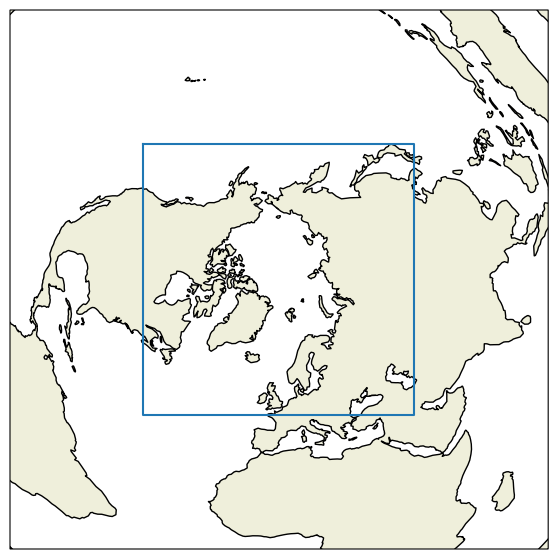

In [82]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection=ease_ccrs)

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.set_extent([-180., 180., 0., 90.], ccrs.PlateCarree())
ax.plot(x, y)